# Computer Assignment 2

Due Date 21 กันยายน 2566 ก่อนเวลา 23.00 น.

ให้ส่งเป็น pdf file ผ่านระบบที่ mango.cmu.ac.th เท่านั้น

Note ห้าม ใช้ library หรือ โปรแกรมสำหรับรูปใดๆ ทั้งสิ้น จะต้องเขียนโปรแกรมด้วยตัวเองทั้งหมด ห้าม ลอกงานคนอื่นถ้าลอกกันมา ทั้งคนให้ลอกและคนลอกจะได้รับคะแนนเป็น 0 ทั้งคู่ และให้แนบ program มาในส่วนของภาคผนวกของรายงานด้วย

การบ้านนี้มี 2 ข้อ

## 2.1 จงทำการทดลองโดยใช้ K-nn และอย่าลืมทำการประเมินประสิทธิภาพของวิธีการนี้ 
เช่นใช้ 10% cross validation หรือ เปรียบเทียบกับ Bayes (Maximum Likelihood) และอื่นๆ ให้ใช้ dataset ใดก็ได้เช่น TWOCLASS, IRIS (Iris และ TWOCLASS มี format ที่เหมือนกันนั่นคือ f1 f2 f3 f4 class-label), CROSS, ELLIPSE (Cross และ Ellipse มี format ที่เหมือนกันนั่นคือ

                                               p#

                                               f1 f2

                                               0 1        %หมายถึง class 2 ถ้าเป็น 1 0 (class 1))

หรือ dataset อื่นๆ ถ้ามี

รายงานควรจะประกอบด้วย

            1. รายละเอียดของทฤษฎีหรือวิธีการต่างๆที่ใช้

            2. การออกแบบ algorithm เช่น pseudo-code, flowchart, ฯลฯ

            3. ผลการทดลอง

            4. การวิเคราะห์การทดลอง เช่น ได้ผลตามที่คาดไว้หรือไม่ มีสิ่งประหลาดเกิดขึ้นหรือไม่ บทสรุปที่ได้คืออะไร ฯลฯ

            5. Well documented, structured, modular program listing

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Maximum Likelihood 
From previous homework, used for comparison

In [31]:
# Step 1: Estimate Parameters (Mean vectors and Covariance matrices)
def estimate_parameters(data):
    num_features = len(data[0]) - 1  # Exclude the last column (class label)
    num_classes = int(max(data, key=lambda x: x[-1])[-1])  # Assuming class labels are 1-indexed

    mean_vectors = {i: np.zeros(num_features) for i in range(1, num_classes + 1)}
    covariance_matrices = {i: np.zeros((num_features, num_features)) for i in range(1, num_classes + 1)}
    class_counts = {i: 0 for i in range(1, num_classes + 1)}

    # Calculate the sum of feature values for each class
    for row in data:
        class_label = int(row[-1])
        class_counts[class_label] += 1
        for i in range(num_features):
            mean_vectors[class_label][i] += row[i]

    # Calculate the mean vectors
    for class_label in mean_vectors:
        mean_vectors[class_label] /= class_counts[class_label]

    # Calculate the covariance matrices
    for row in data:
        class_label = int(row[-1])
        x_minus_mean = row[:-1] - mean_vectors[class_label]
        x_minus_mean = x_minus_mean.reshape((-1, 1))  # Convert to column vector
        covariance_matrices[class_label] += np.dot(x_minus_mean, x_minus_mean.T)

    for class_label in covariance_matrices:
        covariance_matrices[class_label] /= (class_counts[class_label] - 1)

    return mean_vectors, covariance_matrices

# Step 2: Minimum Risk Bayes Decision Theoretic Classifier
def multivariate_normal_pdf(x, mean, covariance_matrix):
    # Calculate the multivariate normal probability density function (PDF) for a given test sample 'x'
    # with the given mean and covariance matrix.
    k = len(x)
    coefficient = 1.0 / ((2 * np.pi) ** (k / 2) * np.linalg.det(covariance_matrix))

    # Calculate (x - mean)
    x_minus_mean = x - mean

    # Calculate the inverse of the covariance matrix
    inv_covariance = np.linalg.inv(covariance_matrix)

    # Calculate the Mahalanobis distance squared
    mahalanobis_dist_sq = np.dot(x_minus_mean, np.dot(inv_covariance, x_minus_mean))

    # Calculate the exponent
    exponent = -0.5 * mahalanobis_dist_sq

    return coefficient * np.exp(exponent)

def minimum_risk_classifier(test_sample, mean_vectors, covariance_matrices, prior_probabilities):
    num_classes = len(mean_vectors)
    risks = [0] * num_classes

    for class_label in range(1, num_classes + 1):
        mean_vector = np.array(mean_vectors[class_label])
        covariance_matrix = np.array(covariance_matrices[class_label])
        
        # Calculate the multivariate normal PDF for the current class
        pdf = multivariate_normal_pdf(test_sample, mean_vector, covariance_matrix)
        
        # Calculate the risk for the current class, which is the negative log-PDF plus the log-prior probability.
        risks[class_label - 1] = -np.log(pdf) + np.log(prior_probabilities[class_label])

    # Choose the class with the minimum risk as the predicted class label.
    predicted_label = np.argmin(risks) + 1
    return predicted_label




# k-NN classifier

In [32]:
class KNNClassifier:
    # k-Nearest Neighbors Classifier
    # first, initial the class with k value
    # then, call the class with test sample and train data
    def __init__(self, k_num=3):
        self.k = k_num

    def __call__(self, test_sample, train_data): 
        k_nearest_neighbors = self.compute_k_nearest_neighbors(test_sample, train_data) # Get the k nearest neighbors
        class_labels = [sample[-1] for sample in k_nearest_neighbors] # Get the class labels of the k nearest neighbors
        predicted_label = int(max(set(class_labels), key=class_labels.count)) # Majority voting
        return predicted_label

    def euclidean_distance(self, x1, x2):
        # Calculate the Euclidean distance between two vectors
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def compute_k_nearest_neighbors(self, test_sample, train_data):
        # Compute the k nearest neighbors of the given test sample
        distances = []

        for train_sample_features in train_data:
            test_sample_ = test_sample[:-1] # Exclude the last column (class label)
            train_sample_features_ = train_sample_features[:-1] # Exclude the last column (class label)
            distance = self.euclidean_distance(test_sample_, train_sample_features_) # Calculate the Euclidean distance
            distances.append((train_sample_features, distance)) # Add the distance along with the sample features to the list

        distances.sort(key=lambda x: x[1]) # Sort the list by the distances
        k_nearest_neighbors = [sample[0] for sample in distances[:self.k]]  # Get the k nearest neighbors
        return k_nearest_neighbors

# 10-fold cross validation

In [33]:
# perform 10-fold cross validation on maximum likelihood classifier and KNN classifier
def cross_validation(data, fold=10, k=3, name='Twoclass', plot=False):
    print(f"Performing {fold}-fold cross validation with k = {k}")
    # shuffle data before cross validation
    np.random.shuffle(data)
    fold_size = len(data) // fold
    accuracy_scores_knn = []
    accuracy_scores_mlc = []

    for i in range(fold):
        # split data into training and test data
        start = i * fold_size
        end = (i + 1) * fold_size
        data_test_fold = data[start:end]
        data_train_fold = np.concatenate([data[:start], data[end:]])
        y_test_fold = data_test_fold[:, -1]

        ############################################# k-NN classifier ####################################################
        print(f"\nFold {i+1}")
        knn = KNNClassifier(k_num=k) # Initialize the k-NN classifier with k = 3
        y_pred = [knn(x, data_train_fold) for x in data_test_fold] # Predict the class labels of the test data
        # display results for each test sample
        print(f"Predicted labels: {y_pred}")
        accuracy = np.sum(y_pred == y_test_fold) / len(y_test_fold) # Calculate the accuracy
        # Display results for the current fold
        print(f"Number of misclassified samples: {np.sum(y_pred != y_test_fold)}")

        accuracy_scores_knn.append(accuracy) # Store the accuracy for the current fold
        print(f"k-NN accuracy: {accuracy:.2f}")

        ###################################### Maximum likelihood classifier #############################################
        # calculate prior probabilities from data_train_fold
        y_train_fold = data_train_fold[:, -1]
        prior_probabilities = {i: np.sum(y_train_fold == i) / len(y_train_fold) for i in np.unique(y_train_fold)}
        # print(f"Prior probabilities: {prior_probabilities}")
        mean_vectors, covariance_matrices = estimate_parameters(data_train_fold)

        mlc_predicted_labels = []  # List to store the predicted labels for the current fold
        for sample in data_test_fold:
            test_sample = sample[:-1]
            # true_label = int(sample[-1])
            predicted_label = minimum_risk_classifier(test_sample, mean_vectors, covariance_matrices, prior_probabilities)
            mlc_predicted_labels.append(predicted_label)  # Store the predicted label for the current sample

        mlc_accuracy = 1 - (np.sum(mlc_predicted_labels != y_test_fold) / len(y_test_fold))

        # Display results for the current fold
        print(f"MLC accuracy: {mlc_accuracy:.2f}")
        accuracy_scores_mlc.append(mlc_accuracy)
        ################################# end of Maximum likelihood classifier ###########################################

        if not plot:
            continue
        else:
            # plot the results of each fold, comparing the two classifiers
            # using 2 subplots
            # x axis: feature 3
            # y axis: feature 4
            # title: fold i
            # subplot 1: k-NN classifier
            # subplot 2: MLC classifier
            plt.figure(figsize=(10, 5))
            plt.suptitle(f"Fold {i+1}")
            plt.subplot(1, 2, 1)
            plt.title(f"k-NN classifier (k = {k}): {accuracy:.2f}")
            plt.xlabel("Feature 3")
            plt.ylabel("Feature 4")
            plt.scatter(data_train_fold[:, 2], data_train_fold[:, 3], c=data_train_fold[:, -1])
            # test data as star with increasing size
            plt.scatter(data_test_fold[:, 2], data_test_fold[:, 3], s=150, marker="*", c=y_pred)
            plt.subplot(1, 2, 2)
            plt.title(f"MLC classifier: {mlc_accuracy:.2f}")
            plt.xlabel("Feature 3")
            plt.ylabel("Feature 4")
            plt.scatter(data_train_fold[:, 2], data_train_fold[:, 3], c=data_train_fold[:, -1])
            plt.scatter(data_test_fold[:, 2], data_test_fold[:, 3], s=150, marker="*", c=mlc_predicted_labels) # PiYG
            plt.legend(("Training", "Test"))
            os.makedirs(f"HW1-{name}", exist_ok=True)
            plt.savefig(f"HW1-{name}/fold_{i+1}.png")
            # plt.show()
            plt.close()

    avg_accuracy_knn = np.mean(accuracy_scores_knn)
    avg_accuracy_mlc = np.mean(accuracy_scores_mlc)
    print(f"\nk-NN average accuracy: {avg_accuracy_knn:.2f}")
    print(f"MLC average accuracy: {avg_accuracy_mlc:.2f}")
    return avg_accuracy_knn, avg_accuracy_mlc
    


# Twoclass dataset

In [34]:
file_path = "TWOCLASS.dat"

try:
    with open(file_path, "r") as file:
        content = file.read()
        data = content.split()
        # print(data)
except FileNotFoundError:
    print("File not found!")

# drop the first 6 elements from list 'data'
data = data[6:]

data_processed = []

for i in range(0, len(data), 5):
    data_processed.append([float(data[i]), float(data[i+1]), float(data[i+2]), \
                           float(data[i+3]), int(data[i+4])])

# print length of data
print("Length of data: ", len(data_processed))

Length of data:  200


## Results

In [35]:
# run cross validation from k = 2 to 10
# collect the average accuracy for each k
k_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]
avg_accuracy_knn_list = []
avg_accuracy_mlc_list = []
for k in k_list:
    avg_accuracy_knn, avg_accuracy_mlc = cross_validation(np.array(data_processed), fold=10, k=k, name='Twoclass', plot=False)
    avg_accuracy_knn_list.append(avg_accuracy_knn)
    avg_accuracy_mlc_list.append(avg_accuracy_mlc)

print(f'\nk: {k_list}')
print(f'Average accuracy for k-NN classifier: {avg_accuracy_knn_list}')
print(f'Average accuracy for MLC classifier: {avg_accuracy_mlc_list}\n')

Performing 10-fold cross validation with k = 2

Fold 1
Predicted labels: [2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2]
Number of misclassified samples: 0
k-NN accuracy: 1.00
MLC accuracy: 1.00

Fold 2
Predicted labels: [2, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2]
Number of misclassified samples: 0
k-NN accuracy: 1.00
MLC accuracy: 1.00

Fold 3
Predicted labels: [1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1]
Number of misclassified samples: 2
k-NN accuracy: 0.90
MLC accuracy: 0.95

Fold 4
Predicted labels: [1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2]
Number of misclassified samples: 0
k-NN accuracy: 1.00
MLC accuracy: 1.00

Fold 5
Predicted labels: [1, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1]
Number of misclassified samples: 0
k-NN accuracy: 1.00
MLC accuracy: 1.00

Fold 6
Predicted labels: [2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1]
Number of misclassified samples: 0
k-NN accuracy: 1.00
MLC ac

MLC accuracy: 0.95

Fold 10
Predicted labels: [1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1]
Number of misclassified samples: 0
k-NN accuracy: 1.00
MLC accuracy: 1.00

k-NN average accuracy: 0.97
MLC average accuracy: 0.98
Performing 10-fold cross validation with k = 3

Fold 1
Predicted labels: [1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1]
Number of misclassified samples: 0
k-NN accuracy: 1.00
MLC accuracy: 1.00

Fold 2
Predicted labels: [1, 2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1]
Number of misclassified samples: 0
k-NN accuracy: 1.00
MLC accuracy: 1.00

Fold 3
Predicted labels: [1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1]
Number of misclassified samples: 0
k-NN accuracy: 1.00
MLC accuracy: 1.00

Fold 4
Predicted labels: [1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1]
Number of misclassified samples: 1
k-NN accuracy: 0.95
MLC accuracy: 1.00

Fold 5
Predicted labels: [1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 

In [36]:
# cross_validation(np.array(data_processed), k = 2, plot = False, name = 'Twoclass')

# IRIS dataset

In [37]:
file_path = "iris.pat"

try:
    with open(file_path, "r") as file:
        content = file.read()
        data = content.split()
        # print(data)
except FileNotFoundError:
    print("File not found!")

header = data[:5]
data = data[5:]

data_processed = []

for i in range(0, len(data), 5):
    data_processed.append([float(data[i]), float(data[i+1]), float(data[i+2]), \
                           float(data[i+3]), int(data[i+4])])

# print length of data
print("Length of data: ", len(data_processed))



Length of data:  150


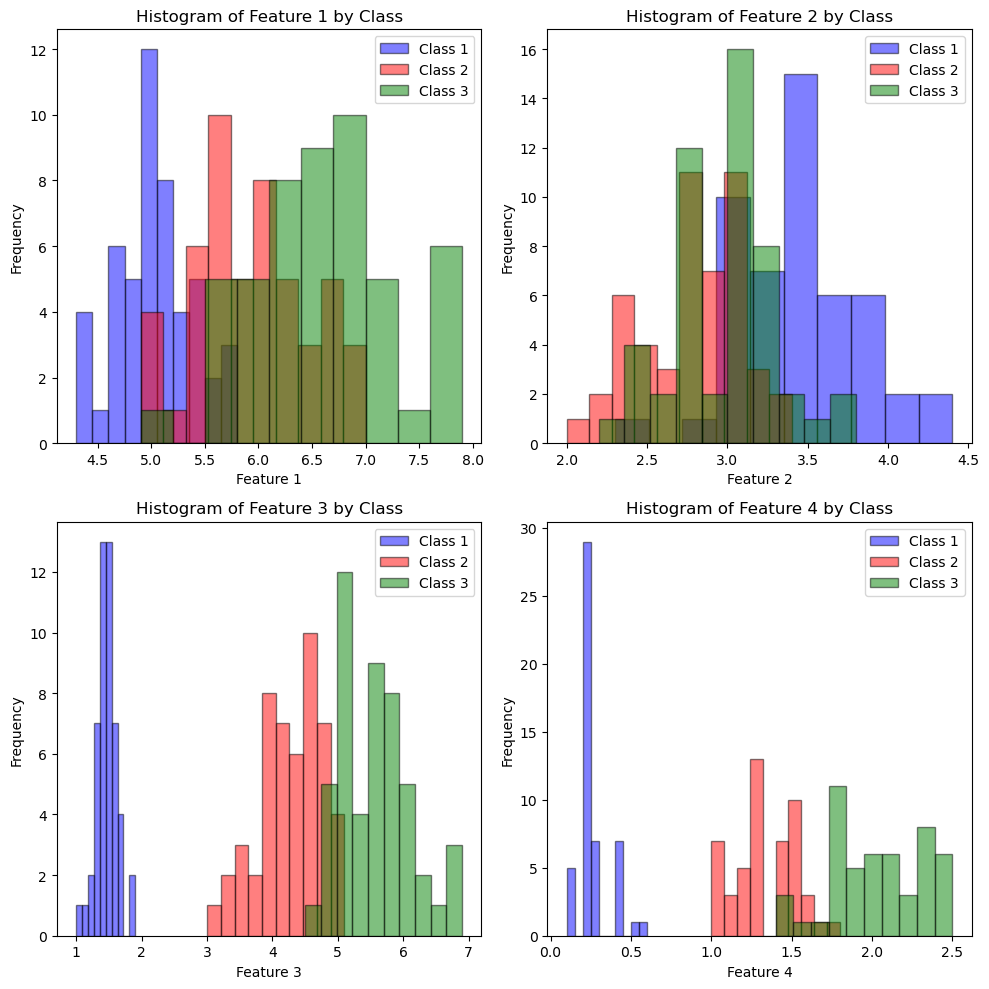

In [38]:
# Separate data by class
class1_data = [sample[:-1] for sample in data_processed if sample[-1] == 1]
class2_data = [sample[:-1] for sample in data_processed if sample[-1] == 2]
class3_data = [sample[:-1] for sample in data_processed if sample[-1] == 3]

# Features (replace these labels with your actual feature names)
feature_labels = ['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4']

# Create a subplot of 2x2 graphs, each with a size of 10x10
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot histograms for each feature
for i in range(len(feature_labels)):
    ax = axs[i // 2, i % 2]  # Get the appropriate subplot
    ax.hist([x[i] for x in class1_data], bins=10, alpha=0.5, color='blue', label='Class 1', edgecolor='black')
    ax.hist([x[i] for x in class2_data], bins=10, alpha=0.5, color='red', label='Class 2', edgecolor='black')
    ax.hist([x[i] for x in class3_data], bins=10, alpha=0.5, color='green', label='Class 3', edgecolor='black')
    ax.set_xlabel(feature_labels[i])
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of {feature_labels[i]} by Class')
    ax.legend()
    # ax.grid(True)

plt.tight_layout()
plt.show()

## Results

In [39]:
# cross_validation(np.array(data_processed), k = 2, name='IRIS', plot = False)

In [40]:
# run cross validation from k = 2 to 10
# collect the average accuracy for each k
k_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]
avg_accuracy_knn_list = []
avg_accuracy_mlc_list = []
for k in k_list:
    avg_accuracy_knn, avg_accuracy_mlc = cross_validation(np.array(data_processed), \
                                                          fold=10, k=k, name='IRIS', plot=False)
    avg_accuracy_knn_list.append(avg_accuracy_knn)
    avg_accuracy_mlc_list.append(avg_accuracy_mlc)

print(f'\nk: {k_list}')
print(f'Average accuracy for k-NN classifier: {avg_accuracy_knn_list}')
print(f'Average accuracy for MLC classifier: {avg_accuracy_mlc_list}\n')

Performing 10-fold cross validation with k = 2

Fold 1
Predicted labels: [1, 3, 3, 1, 3, 3, 2, 1, 2, 2, 3, 2, 2, 1, 2]
Number of misclassified samples: 1
k-NN accuracy: 0.93
MLC accuracy: 1.00

Fold 2
Predicted labels: [3, 2, 3, 2, 2, 3, 3, 2, 3, 1, 1, 1, 3, 2, 3]
Number of misclassified samples: 3
k-NN accuracy: 0.80
MLC accuracy: 0.87

Fold 3
Predicted labels: [2, 3, 3, 1, 2, 1, 3, 1, 3, 3, 1, 1, 3, 1, 1]
Number of misclassified samples: 0
k-NN accuracy: 1.00
MLC accuracy: 1.00

Fold 4
Predicted labels: [2, 3, 1, 2, 2, 2, 1, 2, 1, 1, 3, 3, 3, 2, 2]
Number of misclassified samples: 0
k-NN accuracy: 1.00
MLC accuracy: 1.00

Fold 5
Predicted labels: [3, 2, 2, 2, 2, 2, 1, 3, 2, 3, 2, 1, 1, 1, 2]
Number of misclassified samples: 0
k-NN accuracy: 1.00
MLC accuracy: 1.00

Fold 6
Predicted labels: [3, 2, 1, 2, 1, 1, 2, 3, 3, 2, 3, 3, 1, 3, 3]
Number of misclassified samples: 0
k-NN accuracy: 1.00
MLC accuracy: 1.00

Fold 7
Predicted labels: [1, 2, 3, 1, 1, 1, 1, 3, 2, 1, 2, 2, 1, 1, 1]
Numbe

# CROSS dataset

In [41]:
file_path = "cross.pat"

try:
    with open(file_path, "r") as file:
        content = file.read()
        data = content.split()
        # print(data)
except FileNotFoundError:
    print("File not found!")

data = np.array(data).reshape(-1, 5).T
f1 = data[1].astype(float)
f2 = data[2].astype(float)
class_labels = data[4].astype(int) + 1 # Convert class labels from 0-indexed to 1-indexed
data_processed = np.array([f1, f2, class_labels]).T


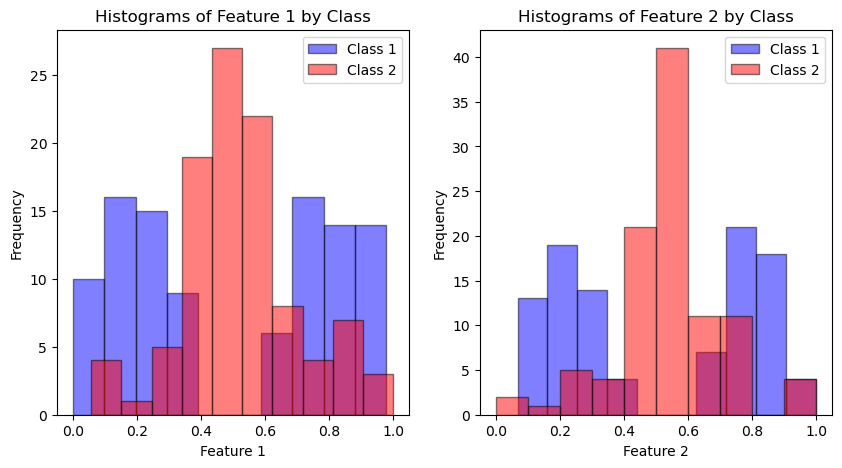

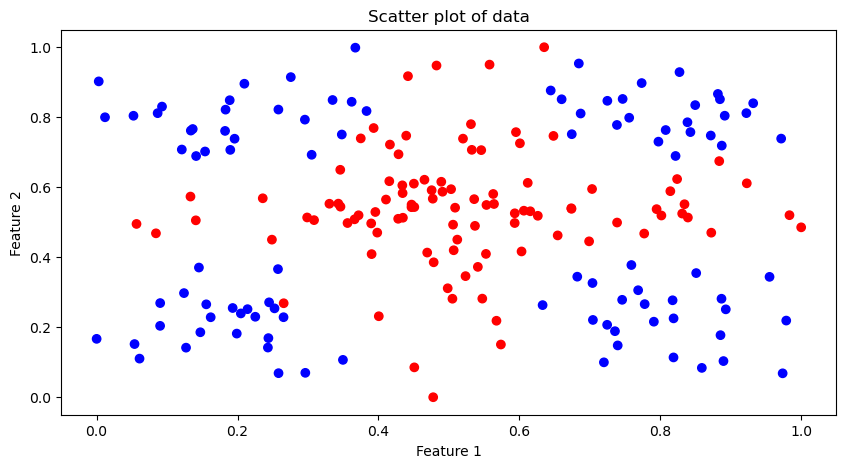

In [42]:
# Separate data by class
class1_data = [sample[:-1] for sample in data_processed if sample[-1] == 1]
class2_data = [sample[:-1] for sample in data_processed if sample[-1] == 2]

# Features (replace these labels with your actual feature names)
feature_labels = ['Feature 1', 'Feature 2']

# Create a subplot of 2x2 graphs, each with a size of 10x10
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot histograms for each feature
for i in range(len(feature_labels)):
    ax = axs[i] 
    ax.hist([x[i] for x in class1_data], bins=10, alpha=0.5, color='blue', label='Class 1', edgecolor='black')
    ax.hist([x[i] for x in class2_data], bins=10, alpha=0.5, color='red', label='Class 2', edgecolor='black')
    ax.set_xlabel(feature_labels[i])
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histograms of {feature_labels[i]} by Class')
    ax.legend()
    # ax.grid(True)

# plot scatter plot of data
plt.figure(figsize=(10, 5))
plt.title("Scatter plot of data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.scatter(f1, f2, c=class_labels, cmap='bwr')
plt.show()

In [43]:
# define the function again because the structure of data is different (only plotting is changed)
# perform 10-fold cross validation on maximum likelihood classifier and KNN classifier
def cross_validation(data, fold=10, k=3, name='CROSS', plot=False):
    print(f"Performing {fold}-fold cross validation with k = {k}")
    # shuffle data before cross validation
    np.random.shuffle(data)
    fold_size = len(data) // fold
    accuracy_scores_knn = []
    accuracy_scores_mlc = []

    for i in range(fold):
        # split data into training and test data
        start = i * fold_size
        end = (i + 1) * fold_size
        data_test_fold = data[start:end]
        data_train_fold = np.concatenate([data[:start], data[end:]])
        y_test_fold = data_test_fold[:, -1]

        ############################################# k-NN classifier ####################################################
        print(f"\nFold {i+1}")
        knn = KNNClassifier(k_num=k) # Initialize the k-NN classifier with k = 3
        y_pred = [knn(x, data_train_fold) for x in data_test_fold] # Predict the class labels of the test data
        # display results for each test sample
        print(f"Predicted labels: {y_pred}")
        accuracy = np.sum(y_pred == y_test_fold) / len(y_test_fold) # Calculate the accuracy
        # Display results for the current fold
        print(f"Number of misclassified samples: {np.sum(y_pred != y_test_fold)}")

        accuracy_scores_knn.append(accuracy) # Store the accuracy for the current fold
        print(f"k-NN accuracy: {accuracy:.2f}")

        ###################################### Maximum likelihood classifier #############################################
        # calculate prior probabilities from data_train_fold
        y_train_fold = data_train_fold[:, -1]
        prior_probabilities = {i: np.sum(y_train_fold == i) / len(y_train_fold) for i in np.unique(y_train_fold)}
        # print(f"Prior probabilities: {prior_probabilities}")
        mean_vectors, covariance_matrices = estimate_parameters(data_train_fold)

        mlc_predicted_labels = []  # List to store the predicted labels for the current fold
        for sample in data_test_fold:
            test_sample = sample[:-1]
            # true_label = int(sample[-1])
            predicted_label = minimum_risk_classifier(test_sample, mean_vectors, covariance_matrices, prior_probabilities)
            mlc_predicted_labels.append(predicted_label)  # Store the predicted label for the current sample

        mlc_accuracy = 1 - (np.sum(mlc_predicted_labels != y_test_fold) / len(y_test_fold))

        # Display results for the current fold
        print(f"MLC accuracy: {mlc_accuracy:.2f}")
        accuracy_scores_mlc.append(mlc_accuracy)
        ################################# end of Maximum likelihood classifier ###########################################

        if not plot:
            continue
        else:
            # plot the results of each fold, comparing the two classifiers
            # using 2 subplots
            # x axis: feature 1
            # y axis: feature 2
            # training data: class 1: red, class 2: blue
            # test data: class 1: orange, class 2: green
            # title: fold i
            # subplot 1: k-NN classifier
            # subplot 2: MLC classifier
            plt.figure(figsize=(10, 5))
            plt.suptitle(f"Fold {i+1}")
            plt.subplot(1, 2, 1)
            plt.title(f"k-NN classifier (k = {k}): {accuracy:.2f}")
            plt.xlabel("Feature 1")
            plt.ylabel("Feature 2")
            plt.scatter(data_train_fold[:, 0], data_train_fold[:, 1], c=data_train_fold[:, -1])
            # test data as star with increasing size
            plt.scatter(data_test_fold[:, 0], data_test_fold[:, 1], s=150, marker="*", c=y_pred)
            plt.subplot(1, 2, 2)
            plt.title(f"MLC classifier: {mlc_accuracy:.2f}")
            plt.xlabel("Feature 1")
            plt.ylabel("Feature 2")
            plt.scatter(data_train_fold[:, 0], data_train_fold[:, 1], c=data_train_fold[:, -1])
            plt.scatter(data_test_fold[:, 0], data_test_fold[:, 1], s=150, marker="*", c=mlc_predicted_labels) # PiYG
            plt.legend(("Training", "Test"))
            os.makedirs(f"HW1-{name}", exist_ok=True)
            plt.savefig(f"HW1-{name}/fold_{i+1}.png")
            # plt.show()
            plt.close()

    avg_accuracy_knn = np.mean(accuracy_scores_knn)
    avg_accuracy_mlc = np.mean(accuracy_scores_mlc)
    print(f"\nk-NN average accuracy: {avg_accuracy_knn:.2f}")
    print(f"MLC average accuracy: {avg_accuracy_mlc:.2f}")
    return avg_accuracy_knn, avg_accuracy_mlc
    

## Results

In [44]:
# cross_validation(np.array(data_processed), k = 2, name='CROSS', plot = False)

In [45]:
# run cross validation from k = 2 to 10
# collect the average accuracy for each k
k_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]
avg_accuracy_knn_list = []
avg_accuracy_mlc_list = []
for k in k_list:
    avg_accuracy_knn, avg_accuracy_mlc = cross_validation(np.array(data_processed), fold=10, k=k, name='CROSS', plot=False)
    avg_accuracy_knn_list.append(avg_accuracy_knn)
    avg_accuracy_mlc_list.append(avg_accuracy_mlc)

print(f'\nk: {k_list}')
print(f'Average accuracy for k-NN classifier: {avg_accuracy_knn_list}')
print(f'Average accuracy for MLC classifier: {avg_accuracy_mlc_list}\n')

Performing 10-fold cross validation with k = 2

Fold 1
Predicted labels: [2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1]
Number of misclassified samples: 1
k-NN accuracy: 0.95
MLC accuracy: 0.70

Fold 2
Predicted labels: [2, 1, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2]
Number of misclassified samples: 4
k-NN accuracy: 0.80
MLC accuracy: 0.70

Fold 3
Predicted labels: [1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2]
Number of misclassified samples: 1
k-NN accuracy: 0.95
MLC accuracy: 0.70

Fold 4
Predicted labels: [2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1]
Number of misclassified samples: 1
k-NN accuracy: 0.95
MLC accuracy: 0.70

Fold 5
Predicted labels: [2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1]
Number of misclassified samples: 2
k-NN accuracy: 0.90
MLC accuracy: 0.75

Fold 6
Predicted labels: [1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2]
Number of misclassified samples: 0
k-NN accuracy: 1.00
MLC ac

# ELLIPSE dataset

In [46]:
file_path = "ellipse.pat"

try:
    with open(file_path, "r") as file:
        content = file.read()
        data = content.split()
        # print(data)
except FileNotFoundError:
    print("File not found!")

data = np.array(data).reshape(-1, 5).T
f1 = data[1].astype(float)
f2 = data[2].astype(float)
class_labels = data[4].astype(int) + 1 # Convert class labels from 0-indexed to 1-indexed
data_processed = np.array([f1, f2, class_labels]).T

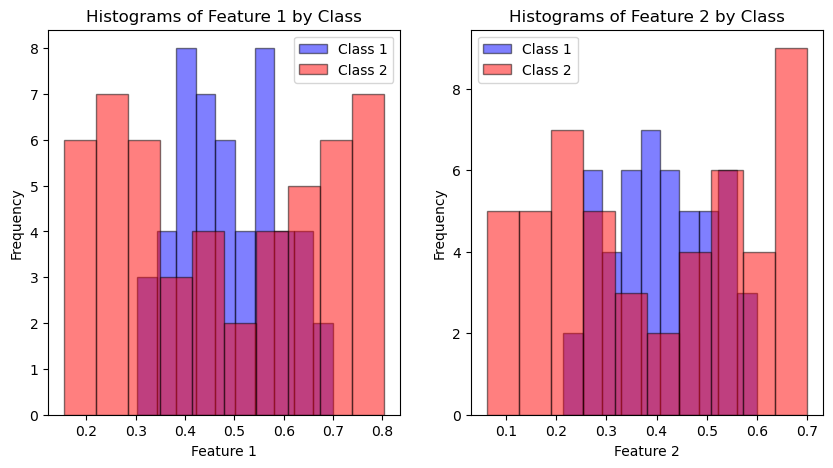

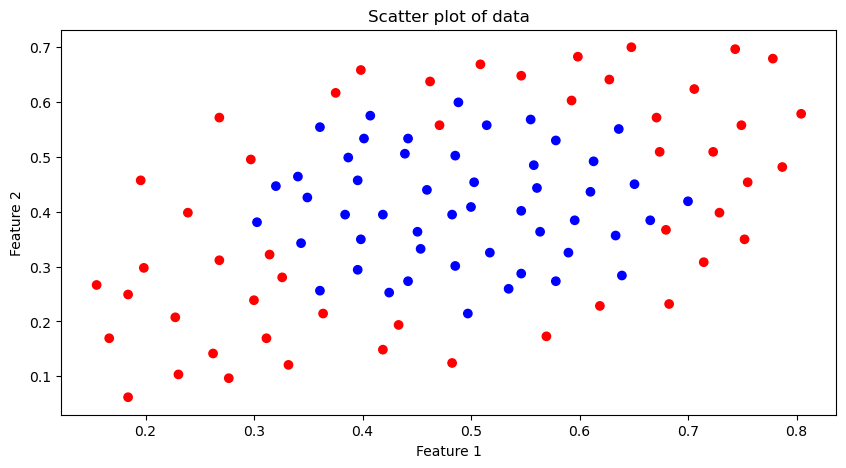

In [47]:
# Separate data by class
class1_data = [sample[:-1] for sample in data_processed if sample[-1] == 1]
class2_data = [sample[:-1] for sample in data_processed if sample[-1] == 2]

# Features (replace these labels with your actual feature names)
feature_labels = ['Feature 1', 'Feature 2']

# Create a subplot of 2x2 graphs, each with a size of 10x10
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot histograms for each feature
for i in range(len(feature_labels)):
    ax = axs[i] 
    ax.hist([x[i] for x in class1_data], bins=10, alpha=0.5, color='blue', label='Class 1', edgecolor='black')
    ax.hist([x[i] for x in class2_data], bins=10, alpha=0.5, color='red', label='Class 2', edgecolor='black')
    ax.set_xlabel(feature_labels[i])
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histograms of {feature_labels[i]} by Class')
    ax.legend()
    # ax.grid(True)

# plot scatter plot of data
plt.figure(figsize=(10, 5))
plt.title("Scatter plot of data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.scatter(f1, f2, c=class_labels, cmap='bwr')
plt.show()

## Results

In [48]:
# cross_validation(np.array(data_processed), k = 2, name='ELLIPSE', plot = False)

In [49]:
# run cross validation from k = 2 to 10
# collect the average accuracy for each k
k_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]
avg_accuracy_knn_list = []
avg_accuracy_mlc_list = []
for k in k_list:
    avg_accuracy_knn, avg_accuracy_mlc = cross_validation(np.array(data_processed), fold=10, k=k, name='ELLIPSE', plot=False)
    avg_accuracy_knn_list.append(avg_accuracy_knn)
    avg_accuracy_mlc_list.append(avg_accuracy_mlc)

print(f'\nk: {k_list}')
print(f'Average accuracy for k-NN classifier: {avg_accuracy_knn_list}')
print(f'Average accuracy for MLC classifier: {avg_accuracy_mlc_list}\n')

Performing 10-fold cross validation with k = 2

Fold 1
Predicted labels: [1, 2, 1, 1, 1, 2, 2, 1, 1, 1]
Number of misclassified samples: 1
k-NN accuracy: 0.90
MLC accuracy: 0.80

Fold 2
Predicted labels: [1, 2, 1, 1, 2, 1, 1, 1, 1, 2]
Number of misclassified samples: 2
k-NN accuracy: 0.80
MLC accuracy: 0.70

Fold 3
Predicted labels: [2, 1, 2, 1, 1, 2, 2, 1, 2, 2]
Number of misclassified samples: 0
k-NN accuracy: 1.00
MLC accuracy: 0.90

Fold 4
Predicted labels: [2, 2, 1, 1, 2, 1, 1, 1, 1, 1]
Number of misclassified samples: 3
k-NN accuracy: 0.70
MLC accuracy: 0.70

Fold 5
Predicted labels: [2, 1, 1, 1, 1, 1, 1, 2, 2, 2]
Number of misclassified samples: 1
k-NN accuracy: 0.90
MLC accuracy: 0.80

Fold 6
Predicted labels: [1, 1, 1, 1, 2, 1, 1, 2, 1, 1]
Number of misclassified samples: 2
k-NN accuracy: 0.80
MLC accuracy: 0.70

Fold 7
Predicted labels: [2, 2, 2, 1, 2, 1, 2, 1, 1, 2]
Number of misclassified samples: 3
k-NN accuracy: 0.70
MLC accuracy: 0.80

Fold 8
Predicted labels: [2, 1, 2, 